In [1]:
# STEP 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# STEP 2: Load and preprocess training data
train = pd.read_csv('data/train.csv')

# Drop unnecessary columns
for col in ['id', 'CustomerId', 'Surname']:
    if col in train.columns:
        train.drop(columns=col, inplace=True)

# One-hot encode categorical variables
train = pd.get_dummies(train, columns=['Gender', 'Geography'], drop_first=True)

# Separate features and target
X = train.drop(columns='Exited')
y = train['Exited']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [3]:
# STEP 3: Train and evaluate models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis()
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    probas = model.predict_proba(X_val)[:, 1]
    results[name] = {
        'ROC AUC': roc_auc_score(y_val, probas),
        'Accuracy': accuracy_score(y_val, preds),
        'Precision': precision_score(y_val, preds),
        'Recall': recall_score(y_val, preds)
    }

results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='ROC AUC', ascending=False))

# Choose the best model (assume Logistic Regression for now)
best_model = LogisticRegression(max_iter=1000)
best_model.fit(X_scaled, y)  # retrain on full training set

                      ROC AUC  Accuracy  Precision    Recall
Random Forest        0.874094  0.858848   0.718085  0.543494
QDA                  0.849683  0.834005   0.625982  0.527247
KNN                  0.829230  0.846275   0.670721  0.531272
LDA                  0.818117  0.834338   0.672626  0.416535
Logistic Regression  0.818048  0.835550   0.696829  0.388641
Decision Tree        0.704827  0.797831   0.519373  0.543494


LogisticRegression(max_iter=1000)

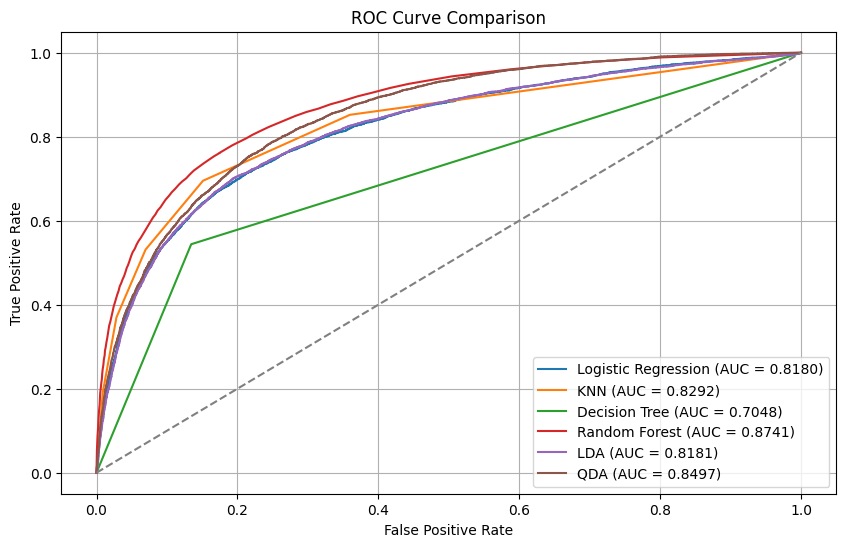

In [4]:
# STEP 4: Plot ROC Curve Comparison for all models

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for name, model in models.items():
    y_scores = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")

# Diagonal line (baseline)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [15]:
# STEP 4 & 5: Prepare test set and make probability predictions

# Load test set and preserve IDs
original_test = pd.read_csv('data/test.csv')
ids = original_test['id'].copy()

# Preprocess test data
test_df = original_test.copy()
test_df.drop(columns=[col for col in ['CustomerId', 'Surname'] if col in test_df.columns], inplace=True)
test_df = pd.get_dummies(test_df, columns=['Gender', 'Geography'], drop_first=True)

# Align test set with training features
for col in X.columns:
    if col not in test_df.columns:
        test_df[col] = 0
test_df = test_df[X.columns]

# Scale
test_scaled = scaler.transform(test_df)

# Predict probabilities
pred_probs = best_model.predict_proba(test_scaled)[:, 1]

# Build submission
submission = pd.DataFrame({
    'id': ids,
    'Exited': pred_probs
})

# Validate
print("✅ Submission shape:", submission.shape)
print("🔍 Duplicate IDs:", submission.duplicated('id').sum())
print(submission.head())

# Save
submission.to_csv('submission.csv', index=False)
print("✅ submission.csv saved.")

✅ Submission shape: (110023, 2)
🔍 Duplicate IDs: 0
       id    Exited
0  165034  0.023605
1  165035  0.578770
2  165036  0.152095
3  165037  0.206990
4  165038  0.423206
✅ submission.csv saved.


## 🔄 Prepare Test Data for Submission

In [6]:

# Load test data
test = pd.read_csv('data/test.csv')

# Save test IDs
test_ids = test['id'] if 'id' in test.columns else np.arange(len(test))

# Drop unused columns
for col in ['id', 'CustomerId', 'Surname']:
    if col in test.columns:
        test.drop(columns=col, inplace=True)

# One-hot encode like training
test = pd.get_dummies(test, columns=['Gender', 'Geography'], drop_first=True)

# Align columns with training data
test = test.reindex(columns=X.columns, fill_value=0)

# Scale using training scaler
X_test_scaled = scaler.transform(test)


## 📦 KNN Submission

In [12]:
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Train the model
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Predict probabilities of churn (class 1)
knn_probs = knn_model.predict_proba(X_test_scaled)[:, 1]

# Create a submission file using churn probability
submission_knn = pd.DataFrame({
    'id': test_ids,
    'Exited': knn_probs  # probability between 0 and 1
})

# Save the submission
submission_knn.to_csv('submission_knn.csv', index=False)



## 🌳 Decision Tree Submission

In [13]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# Train the model
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Predict probability of churn (class 1)
dt_probs = dt_model.predict_proba(X_test_scaled)[:, 1]

# Create submission DataFrame with probabilities
submission_dt = pd.DataFrame({
    'id': test_ids,
    'Exited': dt_probs  # probability of churn (0.0 to 1.0)
})

# Save submission
submission_dt.to_csv('submission_dt.csv', index=False)


## 🌲 Random Forest Submission

In [14]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Train the model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

# Predict probability of churn (class 1)
rf_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

# Create submission DataFrame with probabilities
submission_rf = pd.DataFrame({
    'id': test_ids,
    'Exited': rf_probs  # probability of churn (0.0 to 1.0)
})

# Save submission
submission_rf.to_csv('submission_rf.csv', index=False)
